In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
data = pd.read_parquet('/Users/entirety/Documents/Entirety-AMC/Data/NIFTY_50.parquet')
data['date'] = data['date'].apply(lambda x: x - datetime.timedelta(minutes=15))
data.set_index('date',inplace=True)

In [3]:
data['open'] = data['open'].resample('1H').first()
data['high'] = data['high'].resample('1H').max()
data['low'] = data['low'].resample('1H').min()
data['close'] = data['close'].resample('1H').last()

In [4]:
data.dropna(inplace=True)
data.reset_index(inplace=True)

In [5]:
data['date'] = data['date'].apply(lambda x: x + datetime.timedelta(minutes=15))
data['sma50'] = data['close'].rolling(window=50).mean()

In [6]:
data.dropna(inplace=True)
data.reset_index(drop=True,inplace=True)

In [7]:
trade_log = pd.DataFrame(columns='trade_type,entry_time,entry_price,exit_time,exit_price'.split(','))

In [8]:
long_trade_triggered = 0
for index, row in data[1:].iterrows():
    previous_row = data.iloc[index-1]
    if (previous_row['close'] < previous_row['sma50']) & (row['close'] > row['sma50']) & (long_trade_triggered == 0):
        long_trade_triggered = 1
        trade_log = trade_log.append({'trade_type':'BUY',
                                      'entry_time':row['date'],
                                      'entry_price':row['close']},ignore_index=True)
        
    elif (long_trade_triggered == 1) & (previous_row['close'] > previous_row['sma50']) & (row['close'] < row['sma50']):
        long_trade_triggered = 0
        trade_log = trade_log.append({'exit_time':row['date'],
                                      'exit_price':row['close']},ignore_index=True)

In [9]:
trade_log['exit_time'] = trade_log['exit_time'].shift(-1)
trade_log['exit_price'] = trade_log['exit_price'].shift(-1)

In [10]:
trade_log.dropna(inplace=True)
trade_log.reset_index(drop=True,inplace=True)

In [11]:
trade_log['pnl'] = trade_log['exit_price'] - trade_log['entry_price']

<AxesSubplot:>

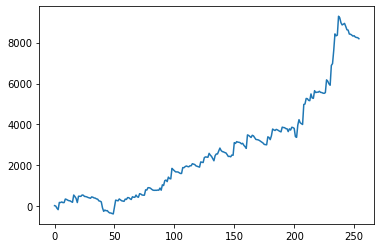

In [12]:
trade_log['pnl'].cumsum().plot()

In [13]:
trade_log['entry_including_slippage'] = trade_log['entry_price'] + (trade_log['entry_price']*0.001)
trade_log['exit_including_slippage'] = trade_log['exit_price'] - (trade_log['exit_price']*0.001)
trade_log['pnl_including_slippage'] = trade_log['exit_including_slippage'] - trade_log['entry_including_slippage'] 

<AxesSubplot:>

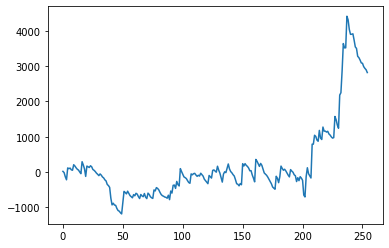

In [14]:
trade_log['pnl_including_slippage'].cumsum().plot()

In [15]:
trade_log['pnl_including_slippage_cumulative_sum'] = trade_log['pnl_including_slippage'].cumsum()

In [16]:
win_rate = round(len(trade_log[trade_log['pnl_including_slippage']>0])/len(trade_log),2)

In [17]:
win_rate

0.27

In [18]:
mean_win = trade_log[trade_log['pnl_including_slippage']>0]['pnl_including_slippage'].mean()
mean_loss = trade_log[trade_log['pnl_including_slippage']<0]['pnl_including_slippage'].mean()
risk_reward = abs(mean_win/mean_loss)
expectancy = round((win_rate*risk_reward) - ((1-win_rate)*1),2)

In [19]:
expectancy

0.16

In [20]:
initial_capital = 200000
trade_log['equity'] = 0
trade_log['rate_of_return'] = 0
for i in range(len(list(trade_log.index))):

    if i == 0:
        trade_log['equity'].iloc[i] = initial_capital + trade_log['pnl_including_slippage'].iloc[i]
        trade_log['rate_of_return'].iloc[i] = (trade_log['pnl_including_slippage'].iloc[i]/initial_capital)*100
    else:
        trade_log['equity'].iloc[i] = trade_log['equity'].iloc[i-1] + trade_log['pnl_including_slippage'].iloc[i]
        trade_log['rate_of_return'].iloc[i] = (trade_log['pnl_including_slippage'].iloc[i]/trade_log['equity'].iloc[i-1])*100

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [21]:
number_of_trading_days_in_a_year = 252
risk_free_interest_rate = 5
mean = trade_log['rate_of_return'].mean() * number_of_trading_days_in_a_year - risk_free_interest_rate
sigma = trade_log['rate_of_return'].std() * np.sqrt(number_of_trading_days_in_a_year)
sharpe_ratio = round(mean/sigma,2)

In [22]:
sharpe_ratio

-2.5

In [23]:
downside_standard_deviation = trade_log[trade_log['rate_of_return']<0]['rate_of_return'].std() * np.sqrt(number_of_trading_days_in_a_year)
sortino_ratio = round(mean/downside_standard_deviation,2)

In [24]:
sortino_ratio

-8.4

In [25]:
trade_log['drawdown'] = trade_log['pnl_including_slippage_cumulative_sum'] - trade_log['pnl_including_slippage_cumulative_sum'].cummax()
max_drawdown = round(trade_log['drawdown'].min(),2)

In [26]:
max_drawdown

-1598.96

In [27]:
max_drawdown_percent = round(max_drawdown/trade_log[trade_log['drawdown'] == trade_log['drawdown'].min()]['equity'].iloc[0]*100,2)

In [28]:
max_drawdown_percent

-0.79

In [29]:
trade_log['recovery'] = 0
for i in range(len(trade_log)):
    if (trade_log['drawdown'].iloc[i] < 0):
        trade_log['recovery'].iloc[i] = trade_log['recovery'].iloc[i-1] + 1
recovery_trades = trade_log['recovery'].max()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [30]:
recovery_trades

144

In [31]:
trade_log_equity_high = trade_log[trade_log['recovery'] == 0]
trade_log_equity_high['number_days_between_equity_highs'] = (trade_log_equity_high['entry_time'] - trade_log_equity_high['entry_time'].shift())
recovery_days = int(trade_log_equity_high['number_days_between_equity_highs'].apply(lambda x: x.days).max())

<ipython-input-31-46d4e2d61eeb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_log_equity_high['number_days_between_equity_highs'] = (trade_log_equity_high['entry_time'] - trade_log_equity_high['entry_time'].shift())


In [32]:
recovery_days

1086

In [33]:
number_of_trading_days_for_this_backtest = (trade_log.iloc[-1]['entry_time'].date() - trade_log.iloc[0]['entry_time'].date()).days
cagr = (((trade_log.iloc[-1]['equity']/initial_capital)**(1/(number_of_trading_days_for_this_backtest/365)))-1)*100
cagr = round(cagr,2)

In [34]:
cagr

0.26

In [35]:
calmar_ratio = round(abs(cagr/max_drawdown_percent),2)

In [36]:
calmar_ratio

0.33